In [21]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 85.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.9 MB/s eta 0:00:00:00:01


In [ ]:
# =============================================================================
# CORE LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import time
import random
import pickle
import warnings
from IPython.display import display, Markdown
import ipywidgets as widgets
import time

# Ignore warnings
warnings.filterwarnings('ignore')

# =============================================================================
# MACHINE LEARNING - SCIKIT LEARN
# =============================================================================
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    accuracy_score, f1_score, precision_score, recall_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# =============================================================================
# MACHINE LEARNING MODELS
# =============================================================================
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# =============================================================================
# DEEP LEARNING - TENSORFLOW / KERAS
# =============================================================================
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, LSTM, Dense, Dropout, 
    GlobalMaxPooling1D, Bidirectional, Concatenate, Attention
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Embedding, Conv1D, LSTM, Dense, Dropout, GlobalMaxPooling1D, Softmax
from tensorflow.keras.layers import Bidirectional, Concatenate, BatchNormalization, Lambda, Activation
from tensorflow.keras.layers import RepeatVector, Permute, Multiply, Flatten
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import *
from tensorflow.keras.layers import GaussianNoise, SpatialDropout1D 


# =============================================================================
# TRANSFORMERS - HUGGINGFACE
# =============================================================================
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, TFBertForSequenceClassification,
    DistilBertTokenizer, TFDistilBertForSequenceClassification,
    AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, 
    AdamWeightDecay, pipeline,
)
from transformers import Trainer, TrainingArguments
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW

# =============================================================================
# PICKLE (OPTIONAL FOR SAVING MODELS)
# =============================================================================
import pickle


In [ ]:
# Load the file
prec_df = pd.read_csv("/kaggle/input/medicine-recommendation-dataset/Training.csv")

# Show column names
print(prec_df.columns)

In [4]:
# Load all the CSVs
base_path = "/kaggle/input/medicine-recommendation-dataset"

files_to_load = [
    "Symptom-severity.csv",
    "Training.csv",
    "description.csv",
    "diets.csv",
    "medications.csv",
    "precautions_df.csv",
    "symtoms_df.csv",
    "workout_df.csv"
]

# Load all files into a dictionary of DataFrames
dataframes = {}
for filename in files_to_load:
    file_path = os.path.join(base_path, filename)
    try:
        df = pd.read_csv(file_path)
        dataframes[filename] = df
    except Exception as e:
        dataframes[filename] = f"Failed to load: {e}"

dataframes.keys()  # show loaded keys (file names)



dict_keys(['Symptom-severity.csv', 'Training.csv', 'description.csv', 'diets.csv', 'medications.csv', 'precautions_df.csv', 'symtoms_df.csv', 'workout_df.csv'])

In [5]:
sample_data = {}

for name, df in dataframes.items():
    if isinstance(df, pd.DataFrame):
        sample_data[name] = df.head(3)

sample_data 

{'Symptom-severity.csv':                 Symptom  weight
 0               itching       1
 1             skin_rash       3
 2  nodal_skin_eruptions       4,
 'Training.csv':    itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
 0        1          1                     1                    0          0   
 1        0          1                     1                    0          0   
 2        1          0                     1                    0          0   
 
    chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
 0       0           0             0        0                 0  ...   
 1       0           0             0        0                 0  ...   
 2       0           0             0        0                 0  ...   
 
    blackheads  scurring  skin_peeling  silver_like_dusting  \
 0           0         0             0                    0   
 1           0         0             0                    0   
 2           0         0  

In [6]:
# ---------------------------
# Load all datasets
# ---------------------------

base_path = "/kaggle/input/medicine-recommendation-dataset"

desc_df = pd.read_csv(os.path.join(base_path, "description.csv"))
train_df = pd.read_csv(os.path.join(base_path, "Training.csv"))
med_df = pd.read_csv(os.path.join(base_path, "medications.csv"))
diet_df = pd.read_csv(os.path.join(base_path, "diets.csv"))
prec_df = pd.read_csv(os.path.join(base_path, "precautions_df.csv"))
workout_df = pd.read_csv(os.path.join(base_path, "workout_df.csv"))
symptom_df = pd.read_csv(os.path.join(base_path, "symtoms_df.csv"))
severity_df = pd.read_csv(os.path.join(base_path, "Symptom-severity.csv"))

# ---------------------------
# Normalization
# ---------------------------

def normalize(text):
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z0-9\s_-]', '', text)  # keep hyphens and underscores
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# ---------------------------
# Prepare Symptoms
# ---------------------------

all_symptoms = set()

all_symptoms.update(severity_df['Symptom'].dropna().apply(normalize))
symptom_cols = [col for col in symptom_df.columns if 'symptom' in col.lower()]
for col in symptom_cols:
    all_symptoms.update(symptom_df[col].dropna().apply(normalize))

# Define symptom columns from training data
symptom_columns = train_df.columns[1:-1]  # Exclude first and last column
for col in symptom_columns:
    all_symptoms.add(normalize(col))

all_symptoms = {s for s in all_symptoms if s and s != 'nan'}

# ---------------------------
# Build Canonical Symptom List
# ---------------------------

all_symptom_list = sorted(list(all_symptoms))

# ---------------------------
# Input Vector Conversion
# ---------------------------

def symptoms_to_input_vector(symptoms, all_symptom_list):
    vec = [0] * len(all_symptom_list)
    norm_symptoms = set(normalize(s) for s in symptoms)
    for i, s in enumerate(all_symptom_list):
        if s in norm_symptoms:
            vec[i] = 1
    return vec

# ---------------------------
# TF-IDF Vectorizer (Optional Alternative)
# ---------------------------

# You can use this for models that support dense vector input
# Uncomment if needed for text-based classification

# all_train_symptom_lists = [
#     [s for s in row[1:-1] if pd.notna(s) and s != '' and s != 'nan']
#     for _, row in train_df.iterrows()
# ]
# train_texts = [" ".join(map(normalize, symptoms)) for symptoms in all_train_symptom_lists]
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(train_texts)

# ---------------------------
# Prepare Training Data
# ---------------------------

X = []
y = []

for _, row in train_df.iterrows():
    # Extract symptom NAMES where value is 1
    symptoms = [col for col in symptom_columns if row[col] == 1]
    vec = symptoms_to_input_vector(symptoms, all_symptom_list)
    X.append(vec)
    y.append(row['prognosis'])

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# PRESERVE NUMERICAL FEATURES FOR CROSS-VALIDATION
disease_X = X  # Save numerical features with proper name
disease_y_encoded = y_encoded  # Save encoded labels

# =============================================================================
# DATA AUGMENTATION FUNCTION
# =============================================================================
def augment_data(X, y, noise_level=0.05, copies=2):
    augmented_X = []
    augmented_y = []
    
    # Convert y to list for consistent handling
    y_list = list(y)
    
    for _ in range(copies):
        for features, label in zip(X, y_list):
            # Convert to numpy array for vectorized operations
            features_arr = np.array(features)
            
            # Create random flip mask
            flip_mask = np.random.rand(len(features_arr)) < noise_level
            
            # Flip values using vectorized operations
            noisy_features = np.where(flip_mask, 1 - features_arr, features_arr)
            
            # Convert back to list and store
            augmented_X.append(noisy_features.tolist())
            augmented_y.append(label)
    
    # Return concatenated results (all as lists)
    return X + augmented_X, y_list + augmented_y

# Apply augmentation BEFORE train/test split
disease_X_aug, disease_y_encoded_aug = augment_data(disease_X, disease_y_encoded)

# =============================================================================
# MODEL TRAINING WITH REGULARIZATION
# =============================================================================

# First split ORIGINAL data (no augmentation)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    disease_X, 
    disease_y_encoded, 
    test_size=0.1, 
    random_state=42
)

# Augmentation ONLY to training set
X_train_aug, y_train_aug = augment_data(X_train_orig, y_train_orig)

# Now train on AUGMENTED training data
model = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_aug, y_train_aug)

# Evaluate on ORIGINAL test set (no augmentation)
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# ---------------------------
# Build Knowledge Maps
# ---------------------------

def get_disease_col(df):
    cols = [c for c in df.columns if 'disease' in c.lower()]
    return cols[0] if cols else None

normalize_disease = lambda d: normalize(d)

desc_map = dict(zip(desc_df['Disease'].apply(normalize_disease), desc_df['Description']))

med_map = {}
med_col = get_disease_col(med_df)
if med_col:
    for disease, group in med_df.groupby(med_col):
        norm = normalize_disease(disease)
        meds = group['Medication'].dropna().tolist()
        med_map[norm] = ", ".join(meds) if meds else "No medication"

diet_map = {}
if 'Disease' in diet_df.columns:
    for disease, group in diet_df.groupby('Disease'):
        norm = normalize_disease(disease)
        diets = group['Diet'].dropna().tolist()
        diet_map[norm] = ", ".join(diets) if diets else "No diet"

prec_map = {}
if 'Disease' in prec_df.columns:
    prec_cols = [col for col in prec_df.columns if 'precaution' in col.lower()]
    for _, row in prec_df.iterrows():
        disease = normalize_disease(row['Disease'])
        precs = [str(row[col]) for col in prec_cols if pd.notna(row[col])]
        prec_map[disease] = ", ".join(precs) if precs else "No precautions"

work_map = {}
work_col = get_disease_col(workout_df)
if work_col and 'workout' in workout_df.columns:
    for disease, group in workout_df.groupby(work_col):
        norm = normalize_disease(disease)
        workouts = group['workout'].dropna().tolist()
        work_map[norm] = ", ".join(workouts) if workouts else "No workout"

# ---------------------------
# Severity mapping
# ---------------------------

severity_map = {}
for s, w in zip(severity_df['Symptom'], severity_df['weight']):
    canonical = normalize(s)
    if canonical not in severity_map or w > severity_map[canonical]:
        severity_map[canonical] = w

# =============================================================================
# PREDICTION FUNCTION WITH CONFIDENCE THRESHOLDING
# =============================================================================
def predict_disease(symptoms, confidence_threshold=0.7):
    input_vector = symptoms_to_input_vector(symptoms, all_symptom_list)
    probs = model.predict_proba([input_vector])[0]
    max_prob = np.max(probs)
    pred_index = np.argmax(probs)
    disease = le.inverse_transform([pred_index])[0]
    norm = normalize_disease(disease)
    
    # Get top 3 predictions
    top_indices = np.argsort(probs)[-3:][::-1]
    top_diseases = le.inverse_transform(top_indices)
    top_probs = probs[top_indices]
    
    if max_prob < confidence_threshold:
        return {
            "warning": "Low confidence prediction",
            "top_predictions": [
                {"disease": d, "confidence": float(p)} 
                for d, p in zip(top_diseases, top_probs)
            ],
            "advice": "Please consult a doctor or provide more symptoms"
        }
    
    return {
        "disease": disease.title(),
        "confidence": float(max_prob),
        "description": desc_map.get(norm, "No description available"),
        "medications": med_map.get(norm, "No medication info"),
        "diet": diet_map.get(norm, "No diet info"),
        "precautions": prec_map.get(norm, "No precautions info"),
        "workout": work_map.get(norm, "No workout info"),
        "other_possibilities": [
            {"disease": d, "confidence": float(p)} 
            for d, p in zip(top_diseases[1:], top_probs[1:])
        ]
    }

# ---------------------------
# Q&A Generation
# ---------------------------

def noisy_question(symptoms):
    kept = [s for s in symptoms if random.random() > 0.15]  # drop some symptoms
    replaced = []
    for s in kept:
        if random.random() < 0.1:
            replaced.append("slight " + s)
        else:
            replaced.append(s)
    random.shuffle(replaced)
    if len(replaced) > 1:
        return "I have " + ", ".join(replaced[:-1]) + " and " + replaced[-1]
    elif replaced:
        return "I have " + replaced[0]
    else:
        return "I feel unwell"


train_questions, train_answers = [], []
val_questions, val_answers = [], []

def build_qa_from_rows(rows, q_list, a_list):
    for _, row in rows.iterrows():
        symptoms = [col for col in symptom_columns if row[col] == 1]
        if not symptoms:
            continue
        annotated = []
        for s in symptoms:
            canonical = normalize(s)
            weight = severity_map.get(canonical, 1)
            severity = "severe" if weight > 6 else "moderate" if weight > 3 else "mild"
            annotated.append(f"{severity} {canonical}")

        # Use noisy question instead of perfect text
        question = noisy_question(annotated)

        disease = normalize(row['prognosis'])
        answer = (
            f"Based on your symptoms, you might have: {disease.title()}\n\n"
            f"**Description:** {desc_map.get(disease, 'No description')}\n\n"
            f"**Medications:** {med_map.get(disease, 'No medication')}\n\n"
            f"**Recommended Diet:** {diet_map.get(disease, 'No diet')}\n\n"
            f"**Precautions:** {prec_map.get(disease, 'No precautions')}\n\n"
            f"**Suggested Workouts:** {work_map.get(disease, 'No workout')}"
        )
        q_list.append(question)
        a_list.append(answer)

# 1. Split raw data first
train_rows, val_rows = train_test_split(train_df, test_size=0.1, random_state=42)

# 2. Prepare containers
train_questions, train_answers = [], []
val_questions, val_answers = [], []

# 3. Generate Q&A
build_qa_from_rows(train_rows, train_questions, train_answers)
build_qa_from_rows(val_rows, val_questions, val_answers)

# 4. Final DataFrames
train_qa = pd.DataFrame({'question': train_questions, 'answer': train_answers})
val_qa = pd.DataFrame({'question': val_questions, 'answer': val_answers})

print(f"Training samples: {len(train_qa)}")
print(f"Validation samples: {len(val_qa)}")


Model Accuracy: 1.00
Training samples: 4428
Validation samples: 492



Performing 10-fold cross-validation...
Verifying data types...
Type of disease_X: <class 'list'>
First element type: <class 'list'>
First element content: [0, 0, 0, 0, 0]

Cross-Validation Results (10-fold):
Average Accuracy: 1.0000 ± 0.0000
Average F1 Score: 1.0000 ± 0.0000
Average Precision: 1.0000 ± 0.0000
Average Recall: 1.0000 ± 0.0000


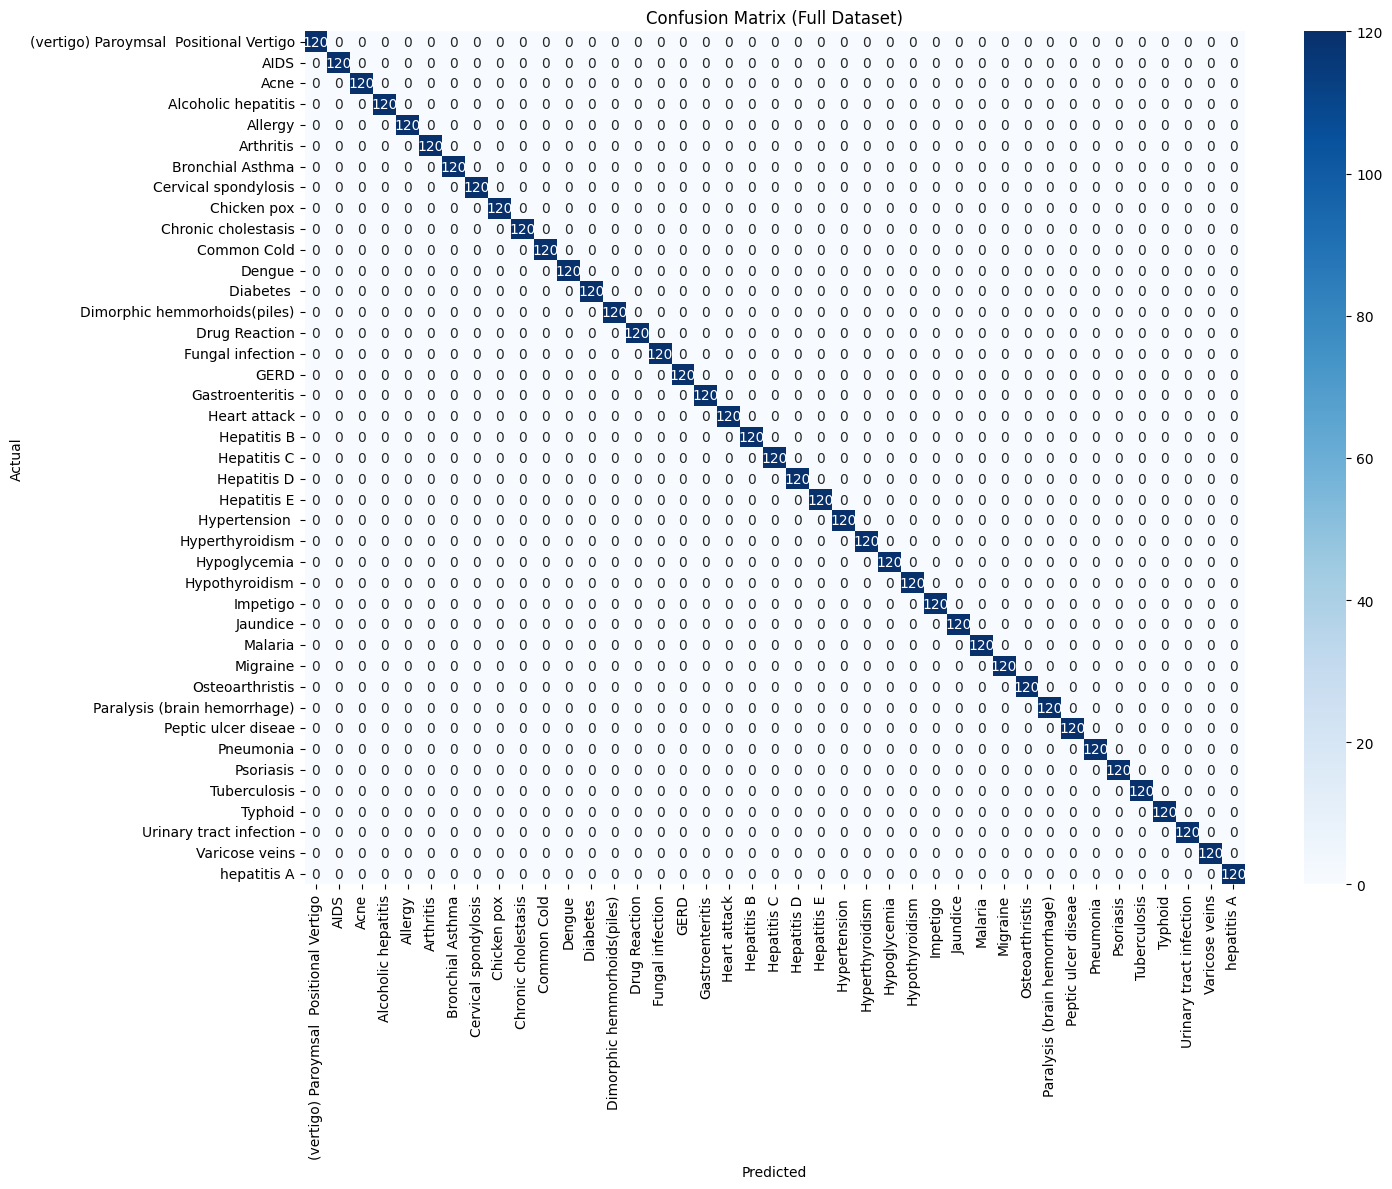


Testing prediction with sample symptoms...
Input symptoms: ['itching', 'skin_rash', 'nodal_skin_eruptions']
Prediction: {'disease': 'Fungal Infection', 'confidence': 0.9886071398607743, 'description': 'Fungal infection is a common skin condition caused by fungi.', 'medications': "['Antifungal Cream', 'Fluconazole', 'Terbinafine', 'Clotrimazole', 'Ketoconazole']", 'diet': "['Antifungal Diet', 'Probiotics', 'Garlic', 'Coconut oil', 'Turmeric']", 'precautions': 'bath twice, use detol or neem in bathing water, keep infected area dry, use clean cloths', 'workout': 'Avoid sugary foods, Consume probiotics, Increase intake of garlic, Include yogurt in diet, Limit processed foods, Stay hydrated, Consume green tea, Eat foods rich in zinc, Include turmeric in diet, Eat fruits and vegetables', 'other_possibilities': [{'disease': 'Acne', 'confidence': 0.0050450450450450456}, {'disease': 'Drug Reaction', 'confidence': 0.003822847751885719}]}


In [7]:
# =============================================================================
# 10-Fold Cross Validation
# =============================================================================

print("\nPerforming 10-fold cross-validation...")

# Verify we have numerical data
print("Verifying data types...")
print(f"Type of disease_X: {type(disease_X)}")
print(f"First element type: {type(disease_X[0])}")
print(f"First element content: {disease_X[0][:5]}")

# Convert to NumPy array for compatibility
X_array = np.array(disease_X)

# Initialize model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
}

# Perform cross-validation
cv_results = cross_validate(
    rf_model,
    X_array,  # Use numerical feature array
    disease_y_encoded,
    cv=10,  # 10 folds
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1  # Use all available cores
)

# Print cross-validation results
print("\nCross-Validation Results (10-fold):")
print(f"Average Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Average F1 Score: {cv_results['test_f1_weighted'].mean():.4f} ± {cv_results['test_f1_weighted'].std():.4f}")
print(f"Average Precision: {cv_results['test_precision_weighted'].mean():.4f} ± {cv_results['test_precision_weighted'].std():.4f}")
print(f"Average Recall: {cv_results['test_recall_weighted'].mean():.4f} ± {cv_results['test_recall_weighted'].std():.4f}")

# =============================================================================
# Confusion Matrix Visualization
# =============================================================================

# Train final model on entire dataset for confusion matrix
model_full = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_full.fit(X_array, disease_y_encoded)
y_pred_full = model_full.predict(X_array)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(disease_y_encoded, y_pred_full), 
            annot=True, fmt='d', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_,
            cmap='Blues')
plt.title('Confusion Matrix (Full Dataset)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# =============================================================================
# Test Prediction Example
# =============================================================================
print("\nTesting prediction with sample symptoms...")
test_symptoms = ['itching', 'skin_rash', 'nodal_skin_eruptions']
print(f"Input symptoms: {test_symptoms}")
print("Prediction:", predict_disease(test_symptoms))

In [8]:
# =============================================================================
# TEST MODEL ROBUSTNESS
# =============================================================================
def test_partial_symptoms():
    """Evaluate model with incomplete symptoms"""
    results = []
    for true_disease in le.classes_:
        # Get original symptoms for disease
        disease_samples = [i for i, d in enumerate(y) if d == true_disease]
        if not disease_samples:
            continue
        sample_idx = disease_samples[0]
        full_symptoms = [col for col in symptom_columns if train_df.iloc[sample_idx][col] == 1]
        
        # Test with progressively fewer symptoms
        for missing_count in range(1, min(3, len(full_symptoms))):  # Test up to 2 missing
            partial_symptoms = full_symptoms[:-missing_count]
            prediction = predict_disease(partial_symptoms)
            
            results.append({
                "true_disease": true_disease,
                "symptoms_reported": len(partial_symptoms),
                "symptoms_total": len(full_symptoms),
                "predicted_disease": prediction.get("disease", "Uncertain"),
                "confidence": prediction.get("confidence", 0),
                "correct": 1 if prediction.get("disease", "") == true_disease else 0
            })
    
    return pd.DataFrame(results)

# Run and display robustness test
robustness_df = test_partial_symptoms()
print("\nModel Robustness Test Results:")
print(robustness_df.groupby('symptoms_reported').agg({
    'confidence': 'mean',
    'correct': 'mean'
}).rename(columns={'correct': 'accuracy'}))



Model Robustness Test Results:
                   confidence  accuracy
symptoms_reported                      
1                    0.000000  0.000000
2                    0.287289  0.111111
3                    0.792404  0.466667
4                    0.742941  0.461538
5                    0.836650  0.400000
6                    0.932560  0.500000
7                    0.813185  1.000000
8                    0.716659  0.666667
9                    0.653116  0.625000
10                   0.696391  0.600000
11                   0.547787  0.666667
12                   0.972873  1.000000
14                   0.888997  1.000000
15                   0.910832  1.000000
16                   0.988016  1.000000


In [9]:
# Check for duplicate symptom patterns with different diseases
symptom_patterns = {}
duplicates = 0

for i, (symptoms, disease) in enumerate(zip(disease_X, le.inverse_transform(disease_y_encoded))):
    pattern = tuple(symptoms)
    if pattern in symptom_patterns:
        if symptom_patterns[pattern] != disease:
            duplicates += 1
            print(f"Pattern conflict: {pattern}")
            print(f"  Disease 1: {symptom_patterns[pattern]}")
            print(f"  Disease 2: {disease}")
    else:
        symptom_patterns[pattern] = disease

print(f"\nTotal duplicate symptom patterns with different diseases: {duplicates}")
print(f"Unique symptom patterns: {len(symptom_patterns)}")
print(f"Total diseases: {len(le.classes_)}")


Total duplicate symptom patterns with different diseases: 0
Unique symptom patterns: 298
Total diseases: 41


In [11]:
# =============================================================================
# DATA PREPARATION FOR HYBRID MODEL
# =============================================================================

# Tokenize questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_qa['question'])

# Convert questions to sequences
train_sequences = tokenizer.texts_to_sequences(train_qa['question'])
val_sequences = tokenizer.texts_to_sequences(val_qa['question'])

# Pad sequences
max_len = 100  # Set your desired sequence length
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post')

# Prepare labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_qa['answer'])
y_val = label_encoder.transform(val_qa['answer'])

# Get vocabulary and class sizes
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
num_classes = len(label_encoder.classes_)

# =============================================================================
# CNN-LSTM-ATTENTION MODEL 
# =============================================================================

def create_enhanced_model(vocab_size, max_len, num_classes):
    # Input layer (like BERT's input_ids)
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    
    # Embedding layer with positional encoding
    embeddings = Embedding(vocab_size, 128)(input_ids)
    
    # Positional Encoding (Transformer-style)
    positions = tf.range(start=0, limit=max_len, delta=1)
    position_embedding = Embedding(input_dim=max_len, output_dim=128)(positions)
    embeddings += position_embedding
    
    # Transformer-inspired Multi-Head Attention
    attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(embeddings, embeddings)
    attn_output = LayerNormalization(epsilon=1e-6)(embeddings + attn_output)
    
    # Multi-scale CNN Feature Extraction
    conv3 = Conv1D(128, 3, activation='relu', padding='same')(attn_output)
    conv5 = Conv1D(128, 5, activation='relu', padding='same')(attn_output)
    conv7 = Conv1D(128, 7, activation='relu', padding='same')(attn_output)
    
    conv3 = GlobalMaxPooling1D()(conv3)
    conv5 = GlobalMaxPooling1D()(conv5)
    conv7 = GlobalMaxPooling1D()(conv7)
    cnn_features = Concatenate()([conv3, conv5, conv7])
    
    # Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(attn_output)
    lstm_out = GlobalMaxPooling1D()(lstm_out)
    
    # Feature Fusion
    combined = Concatenate()([cnn_features, lstm_out])
    
    # Classification Head
    x = Dense(256, activation='gelu')(combined)
    x = Dropout(0.4)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    
    x = Dense(128, activation='gelu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=input_ids, outputs=outputs)

# =============================================================================
# TRAINING LOOP FOR HYBRID MODEL
# =============================================================================
# Initialize model
model = create_enhanced_model(vocab_size, max_len, num_classes)

# Optimizer with weight decay
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=3e-4,
    weight_decay=0.01
)

# Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Prepare datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_padded, y_train)).shuffle(1000).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_padded, y_val)).batch(64)

# Initialize metric trackers
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Custom training loop
for epoch in range(50):
    print(f"\nEpoch {epoch+1}/50")
    
    # Reset metrics at start of epoch
    epoch_train_loss = tf.keras.metrics.Mean()
    epoch_train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
    
    # Training phase
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch, training=True)
            loss = loss_fn(y_batch, logits)
            loss += sum(model.losses)  # Add regularization losses
            
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Update training metrics
        epoch_train_loss.update_state(loss)
        epoch_train_acc.update_state(y_batch, logits)
        
        if step % 50 == 0:
            print(f"Step {step}: Loss = {loss.numpy():.4f}, Acc = {epoch_train_acc.result().numpy():.4f}")
    
    # Record training metrics
    train_loss = epoch_train_loss.result()
    train_acc = epoch_train_acc.result()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation phase
    val_loss = tf.keras.metrics.Mean()
    val_acc = tf.keras.metrics.SparseCategoricalAccuracy()
    
    for x_val_batch, y_val_batch in val_dataset:
        val_logits = model(x_val_batch, training=False)
        v_loss = loss_fn(y_val_batch, val_logits)
        val_loss.update_state(v_loss)
        val_acc.update_state(y_val_batch, val_logits)
    
    # Record validation metrics
    val_losses.append(val_loss.result())
    val_accuracies.append(val_acc.result())
    
    print(f"Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss.result():.4f}, Validation Acc: {val_acc.result():.4f}")



I0000 00:00:1755545216.188995      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Epoch 1/25


I0000 00:00:1755545219.243039      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Step 0: Loss = 4.6730, Acc = 0.0156
Step 50: Loss = 3.8037, Acc = 0.0267
Training Loss: 3.8391, Training Acc: 0.0294
Validation Loss: 3.6772, Validation Acc: 0.0346

Epoch 2/25
Step 0: Loss = 3.6612, Acc = 0.0625
Step 50: Loss = 3.5863, Acc = 0.0453
Training Loss: 3.6368, Training Acc: 0.0544
Validation Loss: 3.1294, Validation Acc: 0.2093

Epoch 3/25
Step 0: Loss = 3.3157, Acc = 0.0625
Step 50: Loss = 2.0484, Acc = 0.2252
Training Loss: 2.6326, Training Acc: 0.2825
Validation Loss: 0.9135, Validation Acc: 0.8638

Epoch 4/25
Step 0: Loss = 1.8167, Acc = 0.4688
Step 50: Loss = 0.9979, Acc = 0.6437
Training Loss: 1.2916, Training Acc: 0.6757
Validation Loss: 0.1883, Validation Acc: 0.9756

Epoch 5/25
Step 0: Loss = 0.8637, Acc = 0.8281
Step 50: Loss = 0.4124, Acc = 0.8318
Training Loss: 0.6657, Training Acc: 0.8426
Validation Loss: 0.0848, Validation Acc: 0.9858

Epoch 6/25
Step 0: Loss = 0.4464, Acc = 0.8906
Step 50: Loss = 0.2500, Acc = 0.9062
Training Loss: 0.4307, Training Acc: 0.910

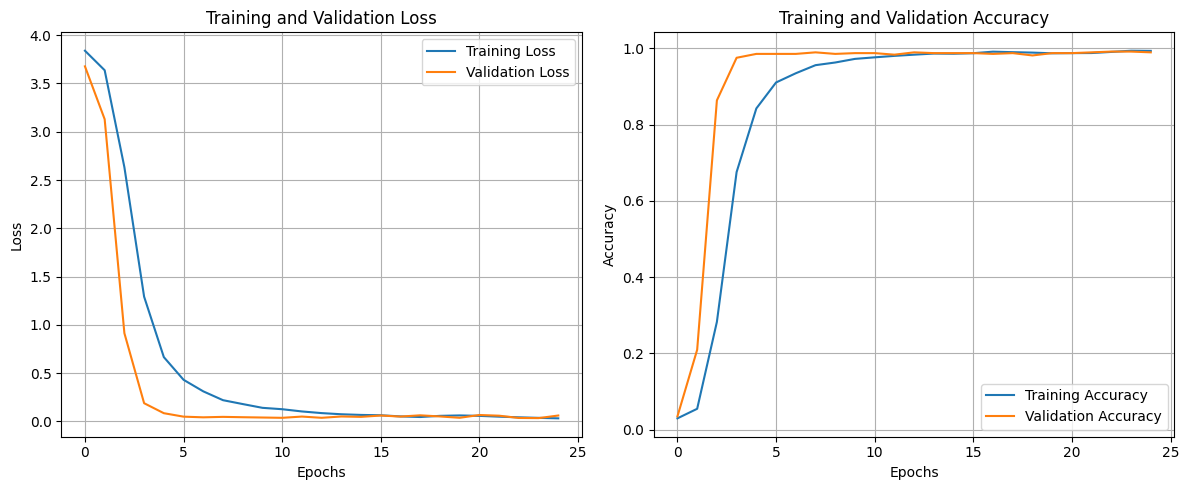

In [13]:
# =============================================================================
# TRAINING VISUALIZATION
# =============================================================================
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      0.90      0.95        10
                                   AIDS       1.00      1.00      1.00        13
                                   Acne       1.00      1.00      1.00        13
                    Alcoholic hepatitis       1.00      1.00      1.00        13
                                Allergy       1.00      1.00      1.00         9
                              Arthritis       1.00      1.00      1.00        20
                       Bronchial Asthma       1.00      1.00      1.00        11
                   Cervical spondylosis       0.80      1.00      0.89         8
                            Chicken pox       0.90      1.00      0.95         9
                    Chronic cholestasis       1.00      1.00      1.00        15
                            Common Cold      

<Figure size 1500x600 with 0 Axes>

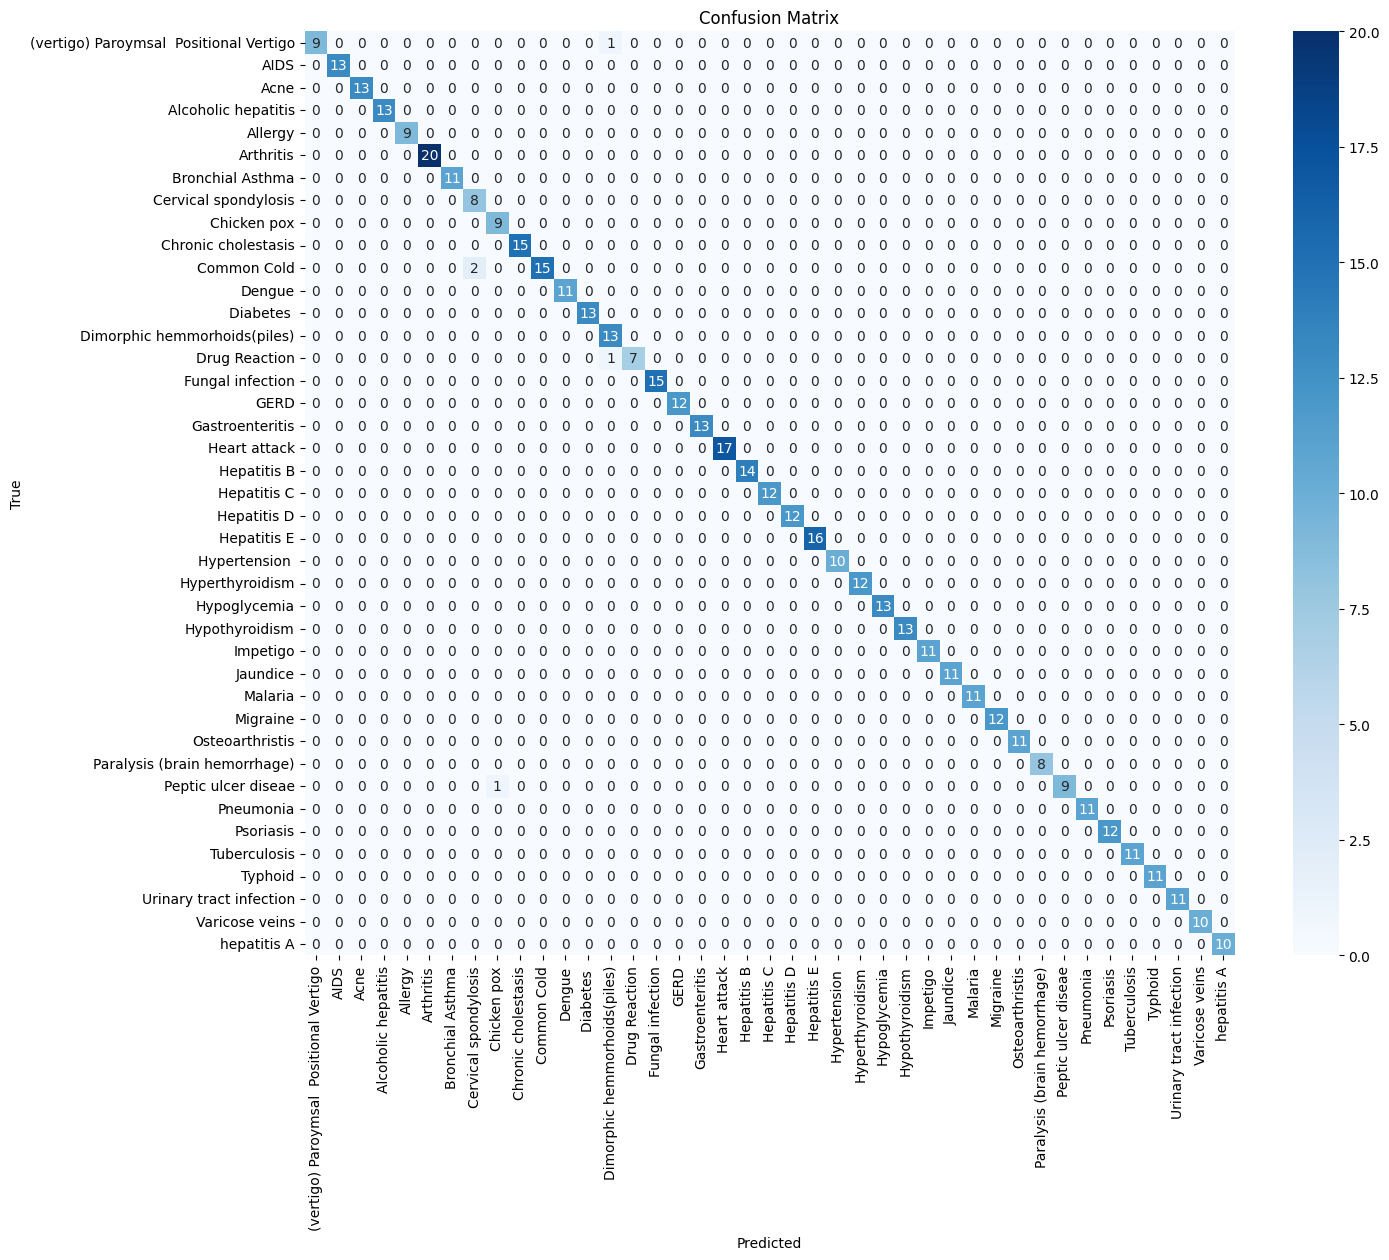

Hybrid Model Validation Accuracy: 0.9898


In [14]:
# =============================================================================
# PERFORMANCE EVALUATION OF HYBRID MODEL
# =============================================================================

# Plot training history
plt.figure(figsize=(15, 6))

# Generate predictions
y_pred = model.predict(val_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Calculate accuracy
hybrid_accuracy = accuracy_score(y_val, y_pred_classes)
print(f"Hybrid Model Validation Accuracy: {hybrid_accuracy:.4f}")

In [16]:
# =============================================================================
# SAVE MODEL
# =============================================================================
# Save model in Kaggle working directory
model.save("/kaggle/working/chatbot_hybrid_model.h5")

# Save tokenizer and label encoder for inference later
import pickle

with open("/kaggle/working/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("/kaggle/working/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Model, tokenizer, and label encoder saved in /kaggle/working/")


Model, tokenizer, and label encoder saved in /kaggle/working/


In [34]:
# =============================================================================
# PREDICTION FUNCTIONS
# =============================================================================

def predict_disease(symptoms):
    """Predict disease with detailed debugging"""
    # Normalize input
    normalized = normalize(symptoms)
    print(f"Normalized symptoms: {normalized}")
    
    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([normalized])
    print(f"Token sequence: {seq}")
    
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    print(f"Padded sequence: {padded}")
    
    # Get predictions
    pred = model.predict(padded, verbose=0)
    print(f"Raw predictions: {pred}")
    
    # Get top 3 predictions
    top3_idx = np.argsort(pred[0])[-3:][::-1]
    top3_diseases = le.inverse_transform(top3_idx)
    top3_probs = pred[0][top3_idx]
    
    print("\nTop 3 predicted diseases:")
    for i, (disease, prob) in enumerate(zip(top3_diseases, top3_probs), 1):
        print(f"{i}. {disease} (confidence: {prob:.4f})")
    
    return top3_diseases[0]

def generate_response(symptoms):
    """Generate friendly response with fallback mechanism"""
    try:
        # Check for general health questions
        normalized = normalize(symptoms)
        mental_health_keywords = ['die', 'suicide', 'kill', 'hopeless', 'worthless', 'depressed']
        serious_conditions_keywords = ['cancer', 'tumor', 'brain', 'blood']
        
        if any(k in normalized for k in mental_health_keywords):
            return (
                "It sounds like you're going through a very difficult situation. "
                "I'm not equipped to offer the help you may need, but you're not alone.\n\n"
                "**Please talk to someone you trust or reach out to a mental health professional or helpline.** "
                "Your life matters, and there are people who care and want to help."
            )
        
        if any(k in normalized for k in serious_conditions_keywords):
            return (
                "It sounds like you're describing a serious health concern. While I can help with general symptom analysis, "
                "**diagnosing conditions like brain or cancer requires input from a qualified medical professional.**\n\n"
                "I strongly recommend scheduling an appointment with a doctor to get the care and support you deserve."
            )

        disease = predict_disease(symptoms)
        norm_disease = normalize_disease(disease)  # ADDED: Normalize the predicted disease
        
        # Retrieve info from knowledge base using NORMALIZED disease name
        desc = desc_map.get(norm_disease, "No detailed description available")
        med = med_map.get(norm_disease, "No specific medication information")
        diet = diet_map.get(norm_disease, "No dietary recommendations")
        prec = prec_map.get(norm_disease, "No specific precautions")
        workout = work_map.get(norm_disease, "No workout suggestions")
        
        # Create friendly response
        response = (
            f"Hello! Based on the symptoms you've described, it appears that you may be experiencing:\n\n"
            f"**→ {disease.title()}**\n\n"
            
            f"**About this condition:**\n"
            f"{desc}\n\n"
            
            f"**Recommended Medications:**\n"
            f"{med}\n\n"
            
            f"**Suggested Diet Plan:**\n"
            f"{diet}\n\n"
            
            f"**Precautionary Measures:**\n"
            f"{prec}\n\n"
            
            f"**Physical Activities You Can Try:**\n"
            f"{workout}\n\n"
            
            f"**Note:**\n"
            f"Please consult a licensed medical professional "
            f"for personalized advice or if your condition does not improve."
        )
        
        return response
    except Exception as e:
        return (
            "⚠️ Oops! I'm having trouble understanding your symptoms. "
            "Could you describe them differently? For example: "
            "\"I have a fever and headache\""
        )

# =============================================================================
# INTERACTIVE INTERFACE
# =============================================================================
# Create interactive widget for testing
symptom_input = widgets.Textarea(
    value='I have fever and headache',
    placeholder='Describe how you\'re feeling...\nExample: "I have cough and chest pain"',
    description='Your symptoms:',
    layout=widgets.Layout(width='90%', height='120px')
)

submit_button = widgets.Button(
    description="Analyze Symptoms", 
    button_style='primary',
    icon='stethoscope',
    layout=widgets.Layout(width='220px', height='40px')
)

output_area = widgets.Output()

def on_submit_clicked(b):
    with output_area:
        output_area.clear_output()
        symptoms = symptom_input.value.strip()
        if symptoms:
            try:
                start_time = time.time()
                display(Markdown("⏳ Analyzing your symptoms..."))
                
                # Get and display response
                response = generate_response(symptoms)
                end_time = time.time()
                
                display(Markdown(f"### 📋 Health Assessment"))
                display(Markdown(f"⏱️ Generated in {end_time - start_time:.2f} seconds"))
                display(Markdown("---"))
                display(Markdown(response))
                display(Markdown("---"))
                display(Markdown("### Would you like me to help you in other health issues?"))
            except Exception as e:
                display(Markdown(f"**Error:** {str(e)}"))
        else:
            display(Markdown("👋 Please describe your symptoms in the box above"))

submit_button.on_click(on_submit_clicked)

# Display widgets
display(Markdown("## 🤖 Health Assistant"))
display(Markdown("Describe your symptoms in English. I'll suggest possible conditions and recommendations."))
display(symptom_input)
display(widgets.HBox([submit_button]))
display(output_area)

## 🤖 Health Assistant

Describe your symptoms in English. I'll suggest possible conditions and recommendations.

Textarea(value='I have fever and headache', description='Your symptoms:', layout=Layout(height='120px', width=…

Output()